### **DCNN-LSTM LOB**

In [ ]:
#Initially we download the zipped data

import os 
if not os.path.isfile('data.zip'):
    !wget https://github.com/LeonardoBerti07/Deep-Learning-Algorithms-for-financial-time-serie-modeling-/blob/main/Datasets/DB2.zip
    !unzip -n data.zip
    print('data downloaded.')
else:
    print('data already existed.')

In [1]:
# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn.functional as F
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Mounted at /content/drive


### **Data**
The dataset in the folder Dataset is the LOBSTER dataset zipped and normalized. I have combined the data of the 5 stocks available for free. I used the version with 10 levels, so we have 40 columns, in fact for every level we have a quadruple wiht the ask and bid prices and with the volumes associated, for more information i reference to the thesis.

I used 70% to do the training, 15% to do the validation and 15% for the testing.

In [2]:
#please change the data_path to your local path

data_path = "/DB2.npy"

dec = np.load(data_path)

train_size = int(0.70 * dec.shape[0])
val_size = int(0.15 * dec.shape[0])

dec_train = dec[:train_size]
dec_val = dec[train_size:val_size+train_size]
dec_test = dec[val_size+train_size:]


In [3]:
#Label the data with the method explained in the thesis

def labeling(X, T):

  [N, D] = X.shape
  print(N)
  x = np.zeros((N - T + 1, T, D))
  for i in range(T, N + 1-T):
      x[i - T] = X[i - T:i, :]

  Y = np.zeros((x.shape[0] - T, 1))
  alpha = 0.00072
  media = []
  for i in range(0, x.shape[0]-T):
    ask_minus = x[i, :, :1]
    bid_minus = x[i, :, 2:3]
    ask_plus = x[i+T, :, :1]
    bid_plus = x[i+T, :, 2:3]
    m_minus = (ask_minus + bid_minus) / 2
    m_minus = np.sum(m_minus) / T
    m_plus = (ask_plus + bid_plus) / 2
    m_plus = np.sum(m_plus) / T
    media.append((m_plus - m_minus) / m_minus)
    if (m_plus - m_minus) / m_minus < -alpha:
      label = 1
    elif (m_plus - m_minus) / m_minus > alpha:
      label = 0
    else:
      label = 2
    Y[i, 0] = label
  
  plt.hist(Y)
  plt.show()
  x = x[:x.shape[0]-T, :, :]
  Y = np.reshape(Y, (Y.shape[0]))
  return x, Y


1477602


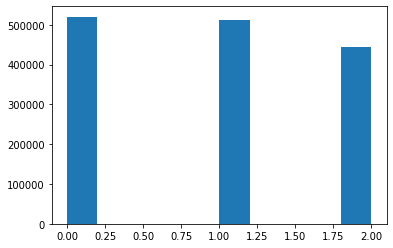

(1477503, 50, 40)
316629


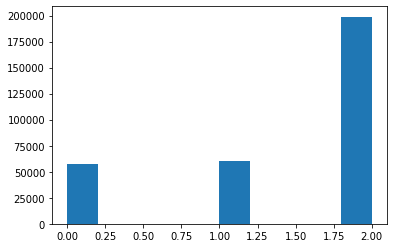

(316530, 50, 40)
316629


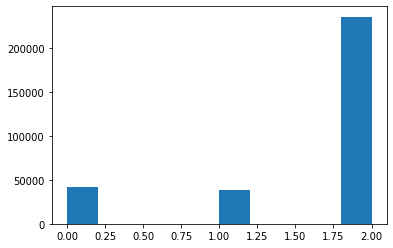

(316530, 50, 40)


In [4]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, num_classes, T):
        """Initialization""" 
        self.num_classes = num_classes
        self.T = T
            
        x, y = labeling(data, self.T)
        print(x.shape)
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]





In [ ]:
#Hyperparameters

batch_size = 64
epochs = 50
T = 50     
lr=0.0001

dataset_train = Dataset(data=dec_train, num_classes=3, T=50)
dataset_val = Dataset(data=dec_val, num_classes=3, T=50)
dataset_test = Dataset(data=dec_test, num_classes=3, T=50)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

### **Model Architecture**
The Architecture of the DCNN is composed of 9 convolutional layers, subsequently there is an inception module composed of 5 parts, each part is made up of 2 convolutional layers, which however are not applied sequentially but each receives in input, the output of the last of the 9 convolutional layers and subsequently all the outputs of each part of the inception module are concatenated and passed in input to the LSTM layer, which has a hidden size of 64. The activation function used is LeakyReLU. The model in total has 1,717,475 parameters.

In [5]:
class deeplob(nn.Module):
    def __init__(self):
        super().__init__()
      
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception module
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(7,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(9,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(11,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=320, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, 3)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x) 
        x_inp4 = self.inp4(x)
        x_inp5 = self.inp5(x)
        x = torch.cat((x_inp1, x_inp2, x_inp3, x_inp4, x_inp5), dim=1)
        #print(x.shape)
        
        x = x.permute(0, 2, 1, 3)
        #print(x.shape)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

### **Model Training**

In [6]:
model = deeplob()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model, '/content/drive/MyDrive/Output/best_model_DeepLOB')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [ ]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=50)


plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

  2%|▏         | 1/50 [09:52<8:03:58, 592.62s/it]

model saved
Epoch 1/50, Train Loss: 0.8488,           Validation Loss: 0.7479, Duration: 0:09:52.620635, Best Val Epoch: 0


### **Model Testing**

In [ ]:
model = torch.load('/content/drive/MyDrive/Output/best_model_DeepLOB')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

In [ ]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))